In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy as sp
import random
import matplotlib
import time
import fct_setup as setup
import fct_general as fct
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

setup.SetPlotParams()


In [3]:
def simulate_current(matrix, I, m, T=100, delta_t=0.1, tau=1):

    timesteps = int(T / delta_t)

    N = matrix.shape[0]
    x = np.zeros((N, timesteps))
#     x[:, 0] = np.random.normal(0, 0.5, N)
    for i in range(timesteps - 1):
        x[:, i + 1] = x[:, i] + delta_t * (- x[:, i] + np.dot(matrix, np.tanh(x[:, i])) + I[:, i]) / tau
        
    return x

### Input-driven dynamics - Gaussian

In [31]:
# Network structure

N = 2000
sigma = 0.12
rho = 0.0

m, n = fct.make_connectivity_vectors(N, sigma, rho)
P = np.outer(m, n)                              

vecs = np.random.randn(2, N)
V = np.insert(vecs, 0, m, axis=0)
m, I, _ = fct.orthogonal_vectors(V)
I = I + 2 * n                          # input current overlapping with n but orthogonal to m 

# Input timeseries 
T = 25
delta_t = 0.01
total_time = int(T/delta_t)
start = int(total_time * 1/5)
stop = int(total_time * 3/5)

current_timeseries = np.zeros((N, total_time))
current_timeseries[:, start:stop] = np.array([I]*(stop-start)).T
n_PCs = 5

# Simulate activity  

activations_all = []
X_proj_m_all = []
X_proj_I_all = []
pca_exp_vars_all = []
pca_components_all = []
pca_sing_vals_all = []
kappas_all = []

gs = [0, 0.2, 0.4, 0.6, 0.8, 1]

repeats = 1

for g in gs: 
    
    print('g: ', g)
    
    X_proj_m = []
    X_proj_I = []
    pca_exp_vars = []
    pca_components = []
    pca_sing_vals = []
    kappas = []

    for r in range(repeats):
        
        chi = np.random.normal(0, np.sqrt(1/(N)), (N, N))  # random part
        J = chi * g  
        M = J + P 

        activations = simulate_current(M, current_timeseries, m, T, delta_t, tau=1)   # N x T
        
        X_proj_m.append([a.dot(m)/(N) for a in activations.T][start:])
        X_proj_I.append([a.dot(I)/(N) for a in activations.T][start:])
        kappas.append([np.abs(np.tanh(a).dot(m)/N) for a in activations.T][start:])  # overlap of activity on m 
        
        X = activations.T                                                     # activations during input current
        Y = (X - np.outer(np.ones(X.shape[0]), np.mean(X, 0)))                # remove mean over time 

        pca = PCA(n_components=n_PCs)
        pca.fit(Y) 
        pca_exp_vars.append(pca.explained_variance_ratio_)
        pca_components.append(pca.components_)
        pca_sing_vals.append([s /np.sum(pca.singular_values_) for s in pca.singular_values_[:n_PCs]])
 
    activations_all.append(activations)
    X_proj_m_all.append(np.mean(X_proj_m, axis=0))
    X_proj_I_all.append(np.mean(X_proj_I, axis=0))
    pca_exp_vars_all.append(np.mean(pca_exp_vars, axis=0))
    pca_components_all.append(np.mean(pca_components, axis=0))
    pca_sing_vals_all.append(np.mean(pca_sing_vals, axis=0))
    kappas_all.append(np.mean(kappas, axis=0))


g:  0
g:  0.2
g:  0.4
g:  0.6
g:  0.8
g:  1


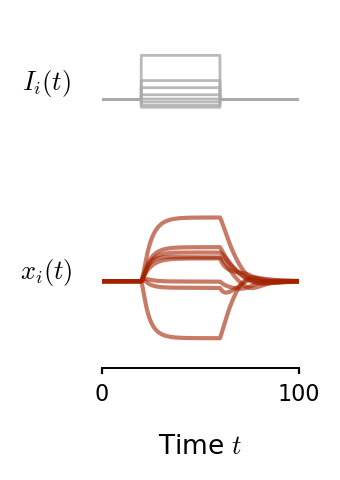

In [32]:
"""
Samples of temporal dynamics 
"""

fig, ax = plt.subplots(2, 1, figsize=(1.8, 2.5), dpi=200)

colors = mpl.pyplot.cm.afmhot(np.linspace(0.25, 0.6, len(gs)))

for i in range(8):
    ax[0].plot(current_timeseries[2*i], c='darkgrey', alpha=0.8)
    ax[1].plot(activations_all[-3][7*i], c=colors[1], lw=1.5, alpha=0.6)
    
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlim([0, 2500])
ax[0].set_ylim([-5, 5])

ax[1].set_xlabel(r'Time $t$')
ax[0].set_ylabel(r'$I_i(t)$', rotation=0, labelpad=20)
ax[1].set_ylabel(r'$x_i(t)$', rotation=0, labelpad=20)
ax[1].set_xlim([0, 2500])
ax[1].set_ylim([-6, 5])
ax[1].set_yticks([])
ax[1].set_xticks([0, 2500])
ax[1].set_xticklabels([0, '100'])

plt.locator_params(axis='x', nbins=2)
sns.despine(ax=ax[0], top=True, right=True, left=True, bottom=True)
sns.despine(ax=ax[1], top=True, right=True, left=True, bottom=False)
fig.tight_layout()

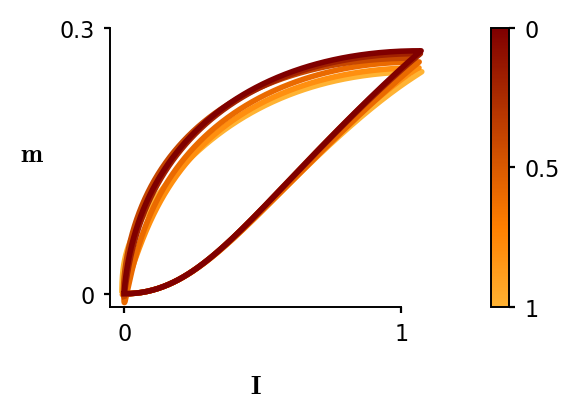

In [33]:
"""
Trajectory in m-I phase plane
"""

# PC projections 

sp = 0

PC1_I = pca_components_all[sp][0].dot(I) * pca_sing_vals_all[sp][0]
PC1_m = pca_components_all[sp][0].dot(m) * pca_sing_vals_all[sp][0]
PC2_I = pca_components_all[sp][1].dot(I) * pca_sing_vals_all[sp][1]
PC2_m = pca_components_all[sp][1].dot(m) * pca_sing_vals_all[sp][1]

fig, ax = plt.subplots(figsize=(3, 2.2), dpi=200)

end = 300
rescale = 0.02
colors = mpl.pyplot.cm.afmhot(np.linspace(0.25, 0.6, len(gs)))

for i in range(len(gs))[::-1]:
    ax.plot(X_proj_I_all[i][:-end], X_proj_m_all[i][:-end], c=colors[i], alpha=1, lw=2, label=r'$g = %.1f$' % gs[i], clip_on=False)

colormap_full = cm.get_cmap('afmhot', 512)
newcmp = ListedColormap(colormap_full(np.linspace(0.25, 0.6, 256)[::-1]))
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=newcmp), ax=ax, aspect=15, pad=0.2)
cbar.set_ticks([0, 0.5, 1]) 
cbar.ax.set_yticklabels(['1', '0.5', '0']) 

ax.set_ylabel(r'$\mathbf{m}$', rotation=0)
ax.set_xlabel(r'$\mathbf{I}$')
ax.set_ylim(-0.015,  0.25)
ax.set_xlim(-0.05,  1)
ax.set_yticks([0, 0.3])
ax.set_yticklabels(['0', '0.3'])

plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=2)
sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout()

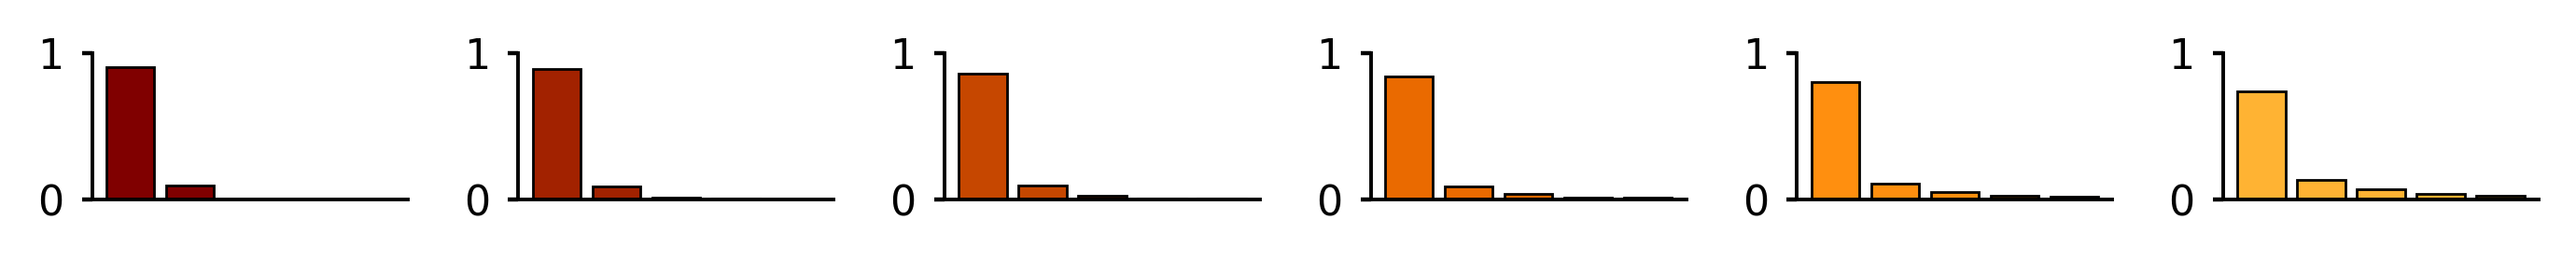

In [35]:
"""
Variance explained by PCs
"""

fig, ax = plt.subplots(1, len(gs), figsize=(7, 0.8), dpi=400)

for i in range(len(gs)):

    ax[i].bar(range(n_PCs), pca_sing_vals_all[i], fc=colors[i], ec='k') 
    ax[i].set_ylim(0, 1)
    ax[i].set_yticks([0, 1])
    ax[i].set_xticks([])
    
sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout()


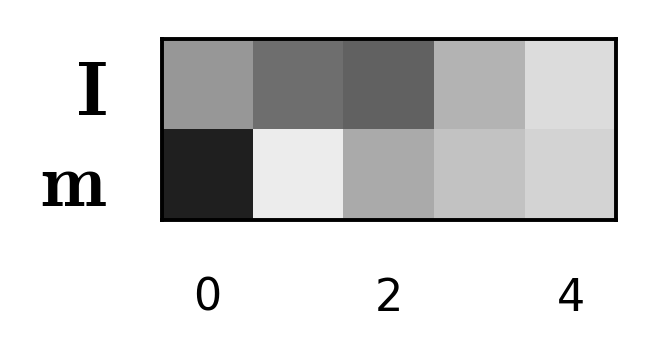

In [38]:
"""
Correlation of PCs with m and I
"""

corr_grid = np.zeros((2, n_PCs))

sg = -2

for i in range(n_PCs):
    corr_grid[0, i] = np.abs(np.corrcoef(pca_components_all[sg][i], I)[0, 1]) 
    corr_grid[1, i] = np.abs(np.corrcoef(pca_components_all[sg][i], m)[0, 1]) 

fig, ax = plt.subplots(figsize=(2, 1), dpi=400)
ax.grid(False)

im = ax.imshow(corr_grid, cmap='binary')
im.set_clim(0, 1)

ax.set_yticks([0, 1])
ax.set_yticklabels([r'$\mathbf{I}$', r'$\mathbf{m}$'], fontsize=14)
ax.tick_params(axis='both', which='both',length=0)
ax.tick_params(axis='both', which='major', pad=10) 
fig.tight_layout()



In [41]:
"""
Activation on m as function of g
"""

gs = np.linspace(0, 1, 10)

repeats = 5

kappas_mean = []
dim_mean = []

for g in gs:
    print('g: ', g)

    kappas = []
    dim = []
    
    for r in range(repeats):
        chi = np.random.normal(0, np.sqrt(1/(N)), (N, N))  # random part
        J = chi * g   
        M = J + P 
        activations = simulate_current(M, current_timeseries, m, T, delta_t, tau=1)  
        kappa = [np.abs(a.dot(m)/(N)) for a in activations.T][start:]  
        kappas.append(np.mean(kappa))
        
        X = activations.T
        Y = (X - np.outer(np.ones(X.shape[0]), np.mean(X, 0)))
        pca = PCA(n_components=n_PCs)
        pca.fit(Y) 
        dim.append(np.sum(pca.explained_variance_)**2 / np.sum([a**2 for a in pca.explained_variance_]))
        
    kappas_mean.append(np.mean(kappas))
    dim_mean.append(np.mean(dim))

kappas_mean = np.array(kappas_mean)

g:  0.0
g:  0.1111111111111111
g:  0.2222222222222222
g:  0.3333333333333333
g:  0.4444444444444444
g:  0.5555555555555556
g:  0.6666666666666666
g:  0.7777777777777777
g:  0.8888888888888888
g:  1.0


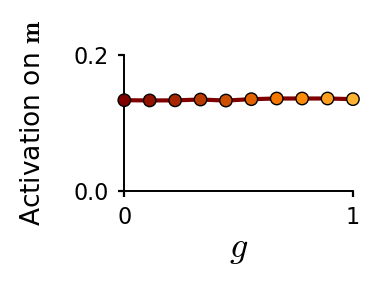

In [45]:
fig, ax = plt.subplots(figsize=(2, 1.4), dpi=200)

colors = mpl.pyplot.cm.afmhot(np.linspace(0.25, 0.6, len(gs)))

ax.plot(gs, kappas_mean, lw=1.5, c=colors[0])
ax.scatter(gs, kappas_mean, fc=colors, ec='black', lw=.5, s=20, zorder=3, clip_on=False)

ax.set_ylabel(r'Activation on $\mathbf{m}$') #, labelpad=1)
ax.set_xlabel(r'$g$', fontsize=13, labelpad=1)
ax.set_xlim(0, 1)
ax.set_xticks([0, 1])
ax.set_ylim(0, 0.2)
ax.set_yticks([0, 0.2])

plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=2)
sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout()

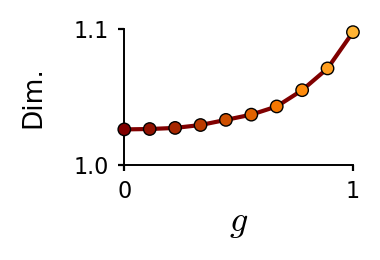

In [220]:
"""
Dimensionality as function of g
"""

fig, ax = plt.subplots(figsize=(2, 1.4), dpi=200)

ax.plot(gs, dim_mean, lw=1.5, c=colors[0])
ax.scatter(gs, dim_mean, fc=colors, ec='black', lw=.5, s=20, zorder=3, clip_on=False)

ax.set_ylabel(r'Dim.') #, labelpad=3)
ax.set_xlabel(r'$g$', fontsize=13, labelpad=1)
ax.set_xlim(0, 1)
ax.set_xticks([0, 1])
ax.set_ylim(1, 1.1)
# ax.set_yticks([0, 0.1])
# ax.set_yticklabels(['0', '0.1'])

plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=2)
sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout()

### Input-driven dynamics - rank-one

In [40]:
# Network structure

N = 2000
sigma = 0.12
rho = 0.0

m, n = fct.make_connectivity_vectors(N, sigma, rho)
P = np.outer(m, n)                              
vecs = np.random.randn(2, N)
V = np.insert(vecs, 0, m, axis=0)
m, I, _ = fct.orthogonal_vectors(V)
I = I + 2 * n                          # input current overlapping with n but orthogonal to m 

# Input timeseries 
T = 25
delta_t = 0.01
total_time = int(T/delta_t)
start = int(total_time * 1/5)
stop = int(total_time * 3/5)
current_timeseries = np.zeros((N, total_time))
current_timeseries[:, start:stop] = np.array([I]*(stop-start)).T

n_PCs = 5

# Simulate activity  
activations_all = []
X_proj_m = []
X_proj_I = []
pca_exp_vars = []
pca_components = []
pca_sing_vals = []

sparsities = np.linspace(0, 0.9, 6)
Cs = (N * (1-sparsities)).astype('int')

for C in Cs: 
    
    print('C: ', C)
    
    P_tilde = fct.sparsify_columns(P, N, C)
    
    activations = simulate_current(P_tilde, current_timeseries, m, T, delta_t, tau=1)   # N x T
    activations_all.append(activations)
    proj_m = [a.dot(m)/(N) for a in activations.T][start:]
    proj_I = [a.dot(I)/(N) for a in activations.T][start:]

    X_proj_m.append(proj_m) 
    X_proj_I.append(proj_I) 
     
    X = activations.T
    Y = (X - np.outer(np.ones(X.shape[0]), np.mean(X, 0)))        # remove mean over time 

    pca = PCA(n_components=n_PCs)
    pca.fit(Y) 
    pca_exp_vars.append(pca.explained_variance_ratio_)
    pca_components.append(pca.components_)
    pca_sing_vals.append([s /np.sum(pca.singular_values_) for s in pca.singular_values_[:n_PCs]])

C:  2000
C:  1640
C:  1280
C:  919
C:  560
C:  199


In [ ]:
"""
Samples of temporal dynamics 
"""

fig, ax = plt.subplots(2, 1, figsize=(1.8, 2.5), dpi=200)

for i in range(8):
    ax[0].plot(current_timeseries[3*i], c='darkgrey', alpha=0.8)
    ax[1].plot(activations_all[0][i], c=colors[0], lw=1.5, alpha=0.6)
    
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlim([0, 2500])
ax[0].set_ylim([-5, 5])

ax[1].set_xlabel(r'Time $t$')
ax[0].set_ylabel(r'$I_i(t)$', rotation=0, labelpad=20)
ax[1].set_ylabel(r'$x_i(t)$', rotation=0, labelpad=20)
ax[1].set_xlim([0, 2500])
ax[1].set_ylim([-6, 3])
ax[1].set_yticks([])
ax[1].set_xticks([0, 2500])
ax[1].set_xticklabels([0, '100'])

plt.locator_params(axis='x', nbins=2)
sns.despine(ax=ax[0], top=True, right=True, left=True, bottom=True)
sns.despine(ax=ax[1], top=True, right=True, left=True, bottom=False)
fig.tight_layout()

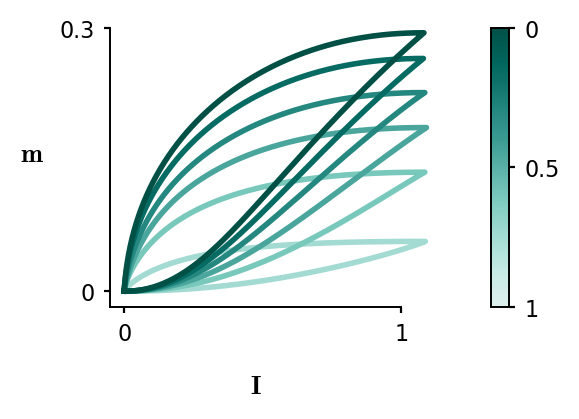

In [39]:
"""
Trajectory in m-I phase plane
"""

# PC projections 

sp = 0

PC1_I = pca_components[sp][0].dot(I) * pca_sing_vals[sp][0]
PC1_m = pca_components[sp][0].dot(m) * pca_sing_vals[sp][0]
PC2_I = pca_components[sp][1].dot(I) * pca_sing_vals[sp][1]
PC2_m = pca_components[sp][1].dot(m) * pca_sing_vals[sp][1]

fig, ax = plt.subplots(figsize=(3, 2.2), dpi=200)

spar = [1 - C / N for C in Cs]
rescale = 0.02
colors = mpl.pyplot.cm.BrBG(np.linspace(0.65, 0.95, len(Cs)))[::-1]
alphas = np.linspace(1, 0.9, len(Cs))

for i in range(len(Cs))[::-1]:
    ax.plot(X_proj_I[i], X_proj_m[i], c=colors[i], alpha=1, lw=2, label=r'$s = %.1f$' % spar[i], clip_on=False)

colormap_full = cm.get_cmap('BrBG', 512)
newcmp = ListedColormap(colormap_full(np.linspace(0.55, 0.95, 256)))
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=newcmp), ax=ax, aspect=15, pad=0.2)
cbar.set_ticks([0, 0.5, 1]) 
cbar.ax.set_yticklabels(['1', '0.5', '0']) 

ax.set_ylabel(r'$\mathbf{m}$', rotation=0)
ax.set_xlabel(r'$\mathbf{I}$')
ax.set_ylim(-0.015,  0.25)
ax.set_xlim(-0.05,  1)
ax.set_yticks([0, 0.25])
ax.set_yticklabels(['0', '0.3'])

# ax.legend(frameon=False, bbox_to_anchor=[1.1, 1])
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=2)
sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout()

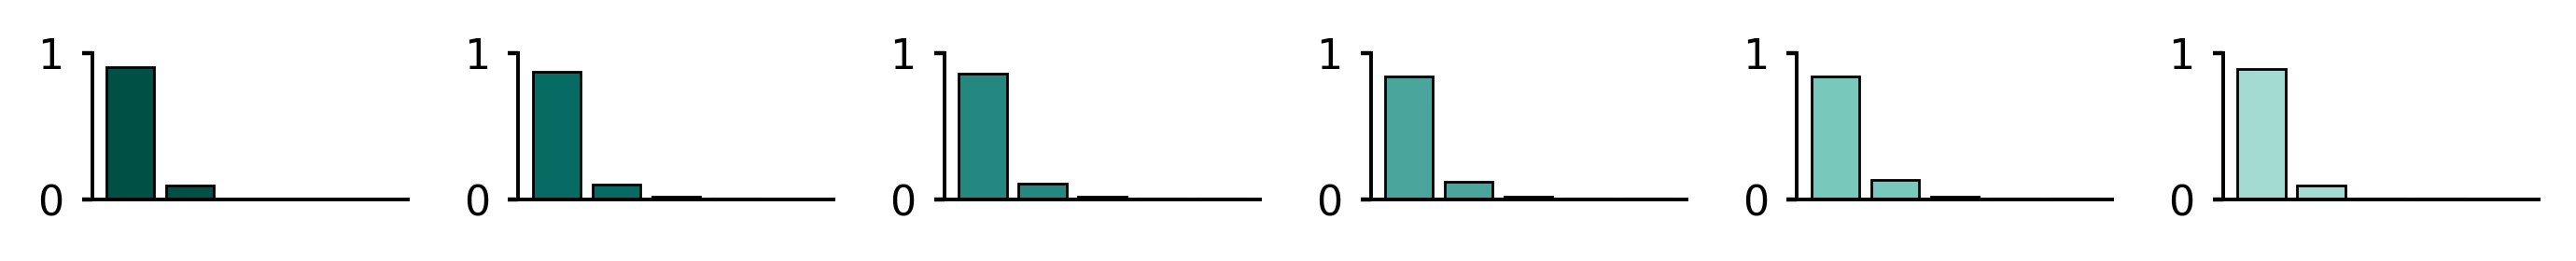

In [81]:
"""
Variance explained by PCs
"""

fig, ax = plt.subplots(1, len(Cs), figsize=(7, 0.8), dpi=400)

for i in range(len(Cs)):

    ax[i].bar(range(n_PCs), pca_sing_vals[i], fc=colors[i], ec='k') 
    ax[i].set_ylim(0, 1)
    ax[i].set_yticks([0, 1])
    ax[i].set_xticks([])
    
sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout()



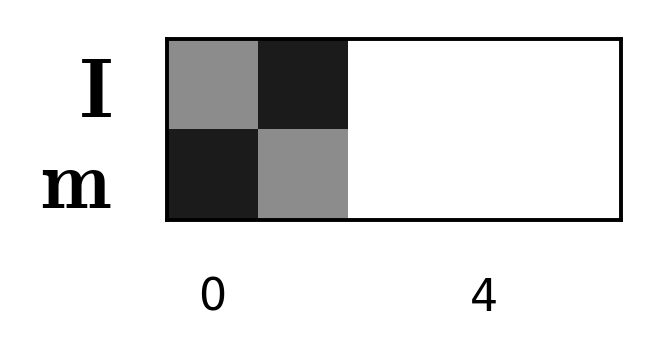

In [85]:
"""
Correlation of PCs with m and I
"""

corr_grid = np.zeros((2, n_PCs))

sp = 0

for i in range(n_PCs):
    corr_grid[0, i] = np.abs(np.corrcoef(pca_components[sp][i], I)[0, 1]) 
    corr_grid[1, i] = np.abs(np.corrcoef(pca_components[sp][i], m)[0, 1]) 

fig, ax = plt.subplots(figsize=(2, 1), dpi=400)
ax.grid(False)

im = ax.imshow(corr_grid, cmap='binary')
# fig.colorbar(im, ax=ax, pad=0.1)
im.set_clim(0, 1)

ax.set_yticks([0, 1])
ax.set_xticks([0, 3])
ax.set_xticklabels(['0', '4'])
ax.set_yticklabels([r'$\mathbf{I}$', r'$\mathbf{m}$'], fontsize=15)
ax.tick_params(axis='both', which='both',length=0)
ax.tick_params(axis='both', which='major', pad=10) 
fig.tight_layout()



In [6]:
"""
Activation on m as function of sparsity
"""

sparsities = np.linspace(0, 0.99, 10)
Cs = (N * (1-sparsities)).astype('int')

repeats = 1

kappas_mean = []
dim_mean = []

for C in Cs:
    print('C: ', C)
  
    kappas = []
    dim = []
    
    for r in range(repeats):
    
        m, n = fct.make_connectivity_vectors(N, sigma, rho)
        P = np.outer(m, n)                              
        vecs = np.random.randn(2, N)
        V = np.insert(vecs, 0, m, axis=0)
        m, I, _ = fct.orthogonal_vectors(V)
        I = I + 2 * n                        # input current overlapping with n but orthogonal to m 

        current_timeseries = np.zeros((N, total_time))
        current_timeseries[:, start:stop] = np.array([I]*(stop-start)).T

        P_tilde = fct.sparsify_columns(P, N, C)

        activations = simulate_current(P_tilde, current_timeseries, m, T, delta_t, tau=1)   # N x T

#         kappa = [(np.tanh(a).dot(m)/(N)) for a in activations.T][start:]  # overlap of activity on m 
        
        kappa = [a.dot(m)/(N) for a in activations.T][start:]  # overlap of activation on m 

        kappas.append(np.mean(kappa))
        
        X = activations.T
        Y = (X - np.outer(np.ones(X.shape[0]), np.mean(X, 0)))
        pca = PCA(n_components=n_PCs)
        pca.fit(Y) 
        dim.append(np.sum(pca.explained_variance_)**2 / np.sum([a**2 for a in pca.explained_variance_]))
        
    kappas_mean.append(np.mean(kappas))
    dim_mean.append(np.mean(dim))
    
kappas_mean = np.array(kappas_mean)

C:  2000
C:  1780
C:  1560
C:  1339
C:  1120
C:  899
C:  679
C:  459
C:  240
C:  20


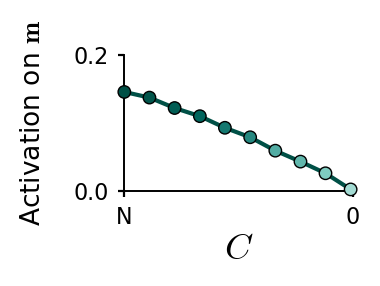

In [51]:
fig, ax = plt.subplots(figsize=(2, 1.4), dpi=200)

colors = mpl.pyplot.cm.BrBG(sequence)[::-1]

ax.plot(Cs, kappas_mean, lw=1.5, c=colors[0])
ax.scatter(Cs, kappas_mean, fc=colors, ec='black', lw=.5, s=20, zorder=3, clip_on=False)

ax.set_ylabel(r'Activation on $\mathbf{m}$')
ax.set_xlabel(r'$C$', fontsize=13, labelpad=1)
ax.set_xlim(N, 0)
ax.set_xticks([N, 0])
ax.set_xticklabels(['N', 0])
ax.set_ylim(0, 0.2)
ax.set_yticks([0, 0.2])
ax.set_yticklabels(['0.0', '0.2'])

plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=2)
sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout()

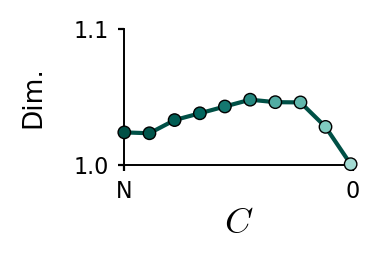

In [50]:
"""
Dimensionality as function of sparsity 
"""

fig, ax = plt.subplots(figsize=(2, 1.4), dpi=200)

ax.plot(Cs, dim_mean, lw=1.5, c=colors[0])
ax.scatter(Cs, dim_mean, fc=colors, ec='black', lw=.5, s=20, zorder=3, clip_on=False)

ax.set_ylabel(r'Dim.') 
ax.set_xlabel(r'$C$', fontsize=13, labelpad=1)
ax.set_xlim(N, 0)
ax.set_xticks([N, 0])
ax.set_xticklabels(['N', 0])
ax.set_ylim(1, 1.1)

plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=2)
sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout()